In [21]:
# Import necessary packages
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

os.chdir("/home/maina/Documents/Air Pollution Monitoring")

# import data_retrival and analysis functions
from data_analysis import *

In [2]:
# Gets the data from firebase, process it and store it in a csv file
filepath = read_data()

# Read the dataset as a pandas dataframe
df = pd.read_csv(filepath)

# Display the first 10 rows
df.head(10)

,timestamp,mq7,mq135,temperature,humidity
0,1639922725,162.0,39.0,24.1,73.0
1,1639923325,135.0,38.0,23.9,75.0
2,1639923927,118.0,36.0,24.0,72.0
3,1639924555,109.0,39.0,24.4,73.0
4,1639925428,102.0,42.0,24.2,74.0
5,1639926056,100.0,42.0,24.2,76.0
6,1639926658,97.0,40.0,24.2,75.0
7,1639927411,96.0,37.0,24.0,77.0
8,1639928191,92.0,37.0,23.9,77.0
9,1639928791,92.0,37.0,23.9,77.0


In [4]:
# Converting the unix time stamp to datetime format
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df["timestamp"] = df["timestamp"].dt.tz_localize('Africa/Nairobi')
df.head()

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0


In [5]:
# Resapmle dataset hourly using mean
df = df.set_index("timestamp")
df = df.resample(rule='H').mean()
df.head()

,mq7,mq135,temperature,humidity
timestamp,,,,
2021-12-19 14:00:00+03:00,125.200000,38.800000,24.120000,73.400000
2021-12-19 15:00:00+03:00,95.000000,38.500000,23.983333,76.666667
2021-12-19 16:00:00+03:00,90.166667,36.166667,23.266667,77.666667
2021-12-19 17:00:00+03:00,97.200000,39.800000,23.240000,78.400000
2021-12-19 18:00:00+03:00,95.500000,39.500000,23.233333,79.833333


In [6]:
# Check if there are any missing values in the dataset
df.isnull().sum()

mq7            0
mq135          0
temperature    0
humidity       0
dtype: int64

In [7]:
# Statistical summary of the dataset columns
df.describe()

,mq7,mq135,temperature,humidity
count,352.000000,352.000000,352.000000,352.000000
mean,87.077023,42.029334,24.492894,62.310476
std,13.675241,7.418984,2.496454,10.194331
min,51.750000,27.833333,21.012821,29.800000
25%,79.437500,38.250000,22.991667,58.005357
50%,84.400000,40.200000,23.837500,66.055000
75%,91.312500,43.350000,25.227841,67.862672
max,153.166667,88.500000,34.000000,81.333333


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

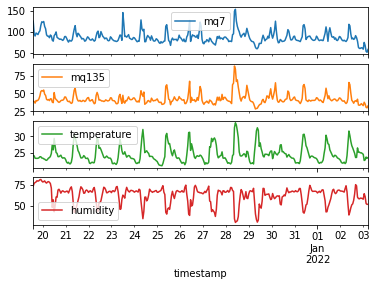

In [9]:
# plot the values against time
df[["mq7", "mq135", "temperature", "humidity"]].plot(subplots=True)

In [11]:
scaler = MinMaxScaler()
df.reset_index(inplace=True)
scaled_data = scaler.fit_transform(df.drop("timestamp", axis=1))

In [12]:
x = scaled_data
y = scaled_data[:,0:2]
print(x.shape, y.shape)

(352, 4) (352, 2)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(281, 4) (71, 4) (281, 2) (71, 2)


In [ ]:
ts_generator = TimeseriesGenerator(x, y, length=6, sampling_rate=1, batch_size=1)
ts_generator[0]

In [15]:
window_length = 5
num_features = 4
batch_size = 16
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [16]:
train_generator[0]

(array([[[0.72423993, 0.18076923, 0.23924975, 0.84605433],
         [0.4264585 , 0.17582418, 0.22872655, 0.90944373],
         [0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263]],
 
        [[0.4264585 , 0.17582418, 0.22872655, 0.90944373],
         [0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263],
         [0.41166804, 0.2032967 , 0.17354393, 0.96119017]],
 
        [[0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263],
         [0.41166804, 0.2032967 , 0.17354393, 0.96119017],
         [0.46918652, 0.23626374, 0.18381046, 0.97089263]],
 
        [[0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(window_length, num_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()

2022-01-12 13:37:02.709224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-12 13:37:02.709256: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 13:37:02.709280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pavilion): /proc/driver/nvidia/version does not exist
2022-01-12 13:37:02.710064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            68096     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5, 128)            0         
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0

In [22]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
                              )
model.compile(
    loss=tf.losses.MeanAbsoluteError(),
    optimizer=Adam(),
    metrics=[MeanAbsoluteError()]
             )

In [23]:
history = model.fit_generator(
    train_generator, 
    epochs=100,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping]
                             )

/tmp/ipykernel_81657/1192819614.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


InvalidArgumentError:  Incompatible shapes: [16,5] vs. [16,2]
	 [[node gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs
 (defined at /home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:464)
]] [Op:__inference_train_function_8063]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/mean_absolute_error/sub/BroadcastGradientArgs:
In[0] gradient_tape/mean_absolute_error/sub/Shape:	
In[1] gradient_tape/mean_absolute_error/sub/Shape_1:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_81657/1192819614.py", line 1, in <module>
>>>     history = model.fit_generator(
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/home/maina/Documents/Air Pollution Monitoring/venv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

In [ ]:
model.evaluate()